## seperate model for 2 context

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline

In [2]:
data_path = '../data'

files = glob.glob(os.path.join(data_path, 'raw', '*', '*'))

files

['../data\\raw\\data-a\\data_dev_A.csv',
 '../data\\raw\\data-a\\data_train_A.csv',
 '../data\\raw\\data-a\\stimulus dan coding guidelines data A.txt',
 '../data\\raw\\data-b\\data_dev_B.csv',
 '../data\\raw\\data-b\\data_train_B.csv',
 '../data\\raw\\data-b\\stimulus dan coding guidelines data B.txt']

In [3]:
d_train_a = pd.read_csv("../data\\raw\\data-a\\data_train_A.csv")

d_train_b = pd.read_csv("../data\\raw\\data-b\\data_train_B.csv")

In [4]:
d_dev_a = pd.read_csv("../data\\raw\\data-a\\data_dev_A.csv")

d_dev_b = pd.read_csv("../data\\raw\\data-b\\data_dev_B.csv")

### cleansing

In [5]:
def cleansing(sentence):
    sentence = sentence.lower()
    word_list = word_tokenize(sentence)
    word_list = [word for word in word_list if len(word) > 2]
    sentence = " ".join(word_list)
    
    return sentence

In [6]:
d_train_a['response_cleansing'] = d_train_a.RESPONSE.apply(cleansing)
d_train_b['response_cleansing'] = d_train_b.RESPONSE.apply(cleansing)
d_dev_a['response_cleansing'] = d_dev_a.RESPONSE.apply(cleansing)
d_dev_b['response_cleansing'] = d_dev_b.RESPONSE.apply(cleansing)

In [7]:
text = " ".join(d_train_b.response_cleansing)

In [8]:
word_list_b = word_tokenize(text)

In [9]:
word_freq = []
for w, f in dict(Counter(word_list_b)).items():
    word_freq.append({'word': w, 'freq': f})

In [10]:
d_word_freq = pd.DataFrame(word_freq)

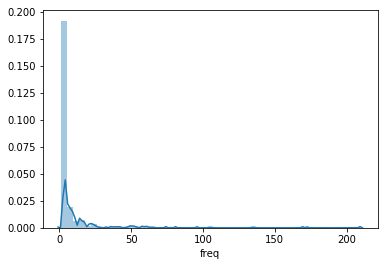

In [11]:
sns.distplot(d_word_freq.freq)

In [ ]:
stopwords = list(d_word_freq[(d_word_freq['freq'] > 50) | (d_word_freq['freq'] < 1)]['word'])

### feature extraction

In [12]:
cv_a = CountVectorizer()
cv_b = CountVectorizer(ngram_range=(1,3), stop_words=None)

In [13]:
X_a = cv_a.fit_transform(d_train_a.response_cleansing)
X_b = cv_b.fit_transform(d_train_b.response_cleansing)

In [14]:
X_dev_a = cv_a.transform(d_dev_a.response_cleansing)
X_dev_b = cv_b.transform(d_dev_b.response_cleansing)

In [15]:
X_a.shape

(268, 655)

In [16]:
X_b.shape

(305, 5204)

### modeling

In [17]:
def evaluation(y_true, y_pred):
    f1score = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return {'f1score': f1score, 'precision': prec, 'recall': recall}

In [23]:
kf = KFold(n_splits=5, random_state=123)

data a

In [ ]:
score_list = []
params = {'booster':'gbtree', 'max_depth': 300, 'eta':1, 'objective':'binary:logistic'}
for train, test in kf.split(X_a, d_train_a.LABEL):

    X_train, y_train = X_a[train], np.array(d_train_a.loc[train, 'LABEL'])
    X_test, y_test = X_a[test], np.array(d_train_a.loc[test, 'LABEL'])

    train = xgb.DMatrix(X_train, label=y_train)
    test = xgb.DMatrix(X_test)

    model = xgb.train(params, train, num_boost_round=2)

    y_pred = model.predict(test)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    score = evaluation(y_test, y_pred)
    score_list.append(score)

In [ ]:
pd.DataFrame(score_list)

data b

In [ ]:
thres_list = np.array(list(range(1, 10))) / 10

In [39]:
score_list = []
params = {'booster':'gbtree', 'max_depth': 3000, 'eta':0.7, 'objective':'binary:logistic'}
for thres in [0.5]:
    for train, test in kf.split(X_b, d_train_b.LABEL):

        X_train, y_train = X_b[train], np.array(d_train_b.loc[train, 'LABEL'])
        X_test, y_test = X_b[test], np.array(d_train_b.loc[test, 'LABEL'])

        train = xgb.DMatrix(X_train, label=y_train)
        test = xgb.DMatrix(X_test)

        model = xgb.train(params, train, num_boost_round=2)

        y_pred = model.predict(test)
        y_pred = np.where(y_pred > thres, 1, 0)

        score = evaluation(y_test, y_pred)
        score['thres'] = thres
        score_list.append(score)

In [40]:
d_score = pd.DataFrame(score_list)

In [41]:
d_score

,f1score,precision,recall,thres
0,0.739726,0.729730,0.750000,0.5
1,0.593750,0.575758,0.612903,0.5
2,0.571429,0.526316,0.625000,0.5
3,0.724638,0.735294,0.714286,0.5
4,0.716418,0.727273,0.705882,0.5
